In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Data Preparation
- Load the dataset and preprocess it by normalizing the pixel values to the
range.
- Divide the dataset into training and testing sets (e.g., 80% training, 20%
testing).

In [17]:
# Data Preparation
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize the data and flatten it (28x28 -> 784)
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255.0
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255.0

# RBM Implementation
- Define an RBM using a deep learning library (e.g., PyTorch, TensorFlow, or
Scikit-learn).
- Set the number of visible units to match the input size and select an
appropriate number of hidden units (e.g., 128 or 256).

In [18]:
class RBM:
    def __init__(self, visible_size, hidden_size):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.weights = tf.Variable(tf.random.normal([visible_size, hidden_size], stddev=0.1))
        self.visible_bias = tf.Variable(tf.zeros([visible_size]))
        self.hidden_bias = tf.Variable(tf.zeros([hidden_size]))

    def sample_h_given_v(self, visible):
        p_h_given_v = tf.nn.sigmoid(tf.matmul(visible, self.weights) + self.hidden_bias)
        return tf.nn.relu(tf.sign(p_h_given_v - tf.random.uniform(tf.shape(p_h_given_v))))

    def sample_v_given_h(self, hidden):
        p_v_given_h = tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(self.weights)) + self.visible_bias)
        return tf.nn.relu(tf.sign(p_v_given_h - tf.random.uniform(tf.shape(p_v_given_h))))

    def contrastive_divergence(self, input_data, k=1, learning_rate=0.01):
        positive_hidden_probs = tf.nn.sigmoid(tf.matmul(input_data, self.weights) + self.hidden_bias)
        positive_hidden_states = tf.nn.relu(tf.sign(positive_hidden_probs - tf.random.uniform(tf.shape(positive_hidden_probs))))

        for _ in range(k):
            negative_visible_probs = tf.nn.sigmoid(tf.matmul(positive_hidden_states, tf.transpose(self.weights)) + self.visible_bias)
            negative_visible_states = tf.nn.relu(tf.sign(negative_visible_probs - tf.random.uniform(tf.shape(negative_visible_probs))))

            negative_hidden_probs = tf.nn.sigmoid(tf.matmul(negative_visible_states, self.weights) + self.hidden_bias)
            negative_hidden_states = tf.nn.relu(tf.sign(negative_hidden_probs - tf.random.uniform(tf.shape(negative_hidden_probs))))

        positive_associations = tf.matmul(tf.transpose(input_data), positive_hidden_probs)
        negative_associations = tf.matmul(tf.transpose(negative_visible_states), negative_hidden_probs)

        self.weights = self.weights + learning_rate * (positive_associations - negative_associations)
        self.visible_bias = self.visible_bias + learning_rate * tf.reduce_mean(input_data - negative_visible_probs, axis=0)
        self.hidden_bias = self.hidden_bias + learning_rate * tf.reduce_mean(positive_hidden_probs - negative_hidden_probs, axis=0)

In [19]:
visible_size = x_train.shape[1]
hidden_size = 256
rbm = RBM(visible_size, hidden_size)

# Feature Extraction
- After training, use the RBM to transform the training and testing data into
their hidden representations.
- Save the hidden representations as feature vectors.

In [20]:
epochs = 10
batch_size = 64
learning_rate = 0.01
k = 1

for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        batch = x_train[i:i + batch_size]
        rbm.contrastive_divergence(batch, k, learning_rate)

    print(f"Epoch {epoch + 1}/{epochs} completed.")

Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.


In [21]:
# After training, transform the training and test data into their hidden representations
def extract_features(rbm, data):
    hidden_probs = tf.nn.sigmoid(tf.matmul(data, rbm.weights) + rbm.hidden_bias)
    hidden_states = tf.nn.relu(tf.sign(hidden_probs - tf.random.uniform(tf.shape(hidden_probs))))
    return hidden_states.numpy()

# Extract hidden features for training and testing data
x_train_features = extract_features(rbm, x_train)
x_test_features = extract_features(rbm, x_test)

# Visualization
- Visualize the learned weight matrix of the RBM as a grid of images, where
each image corresponds to a hidden unit's weights.

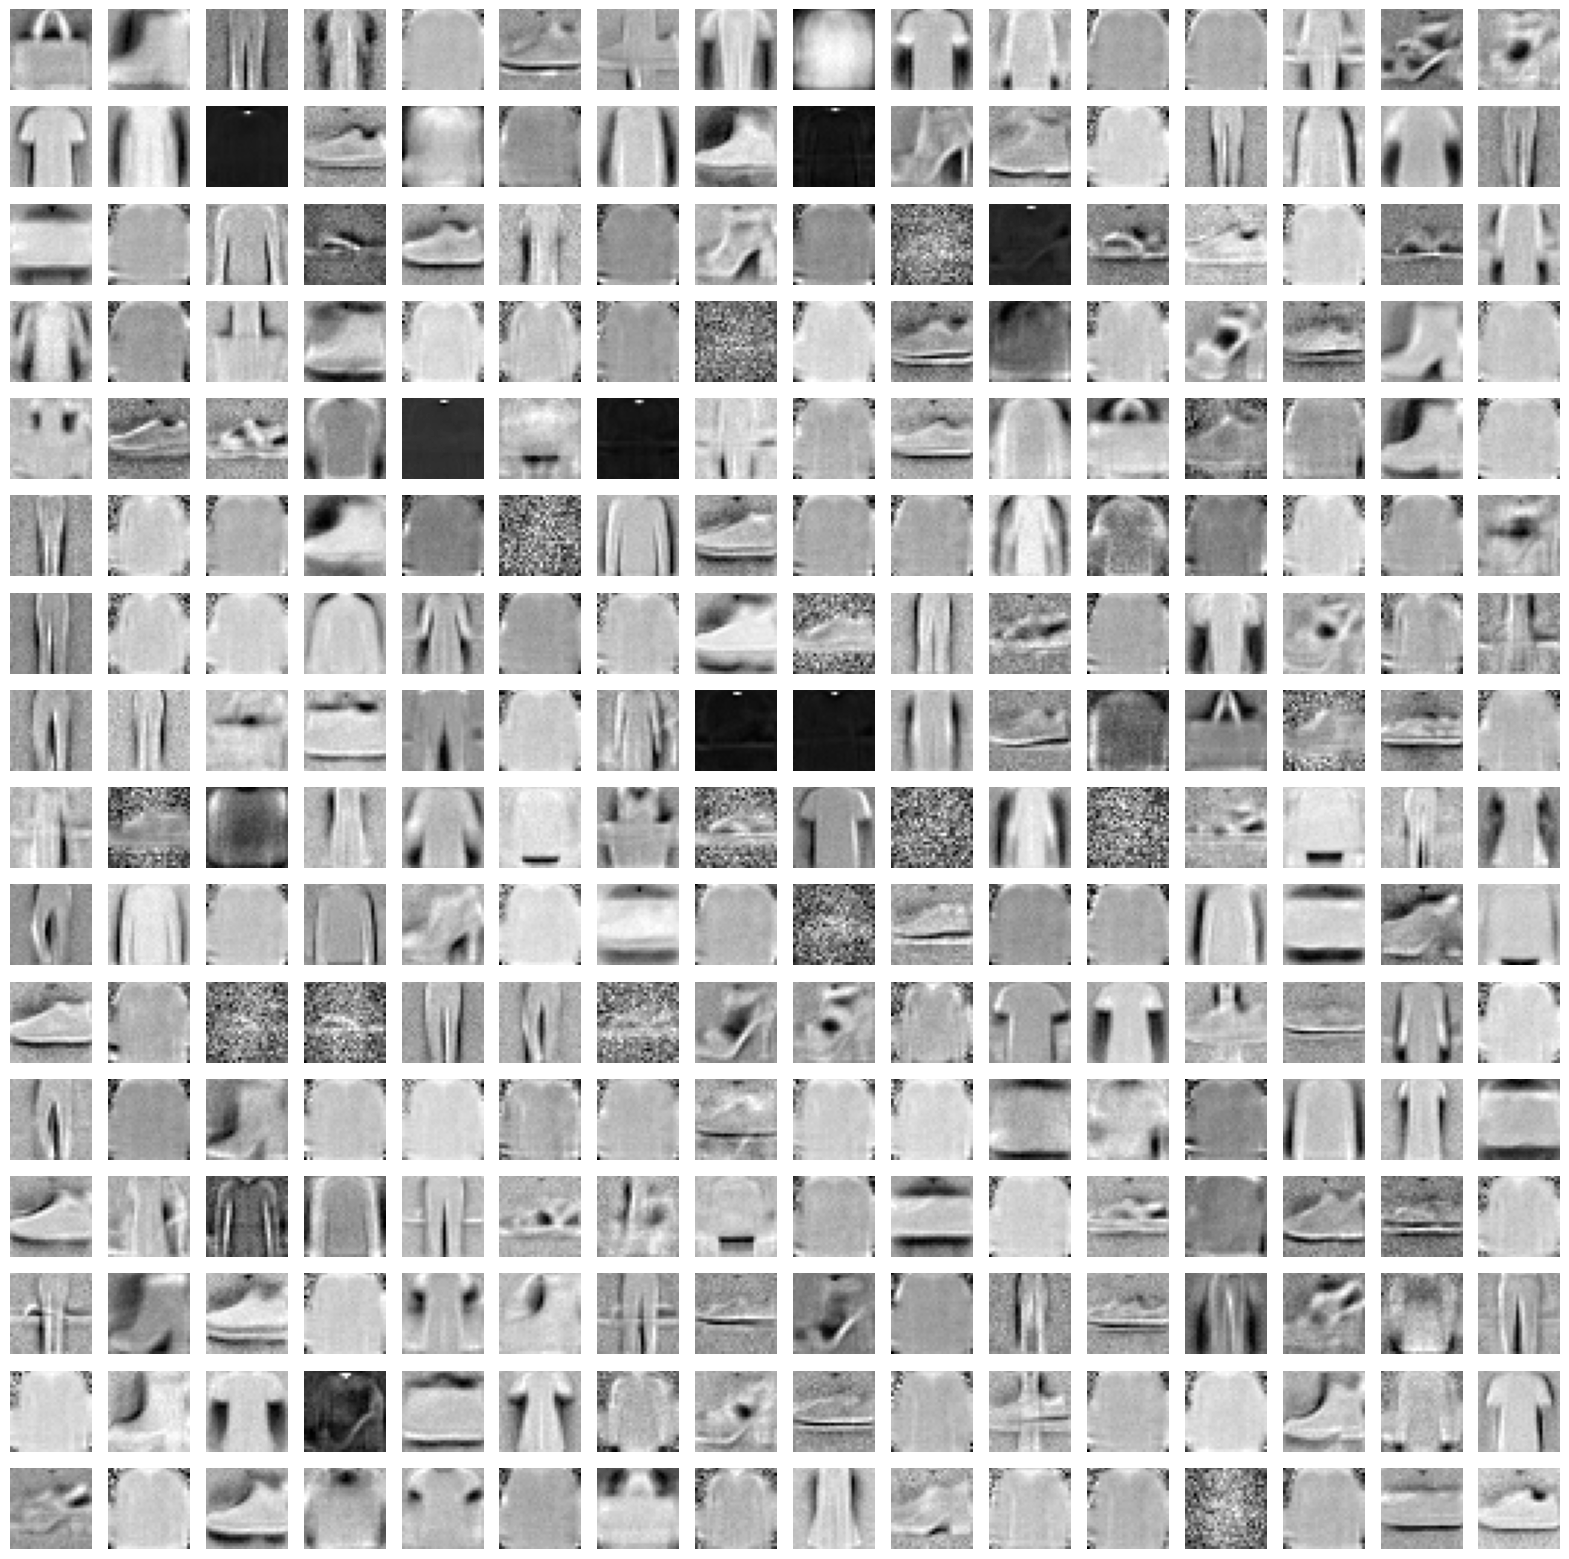

In [22]:
def visualize_weights(rbm):
    W = rbm.weights.numpy()
    n_hidden = W.shape[1]
    n_cols = 16
    n_rows = n_hidden // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    for i in range(n_hidden):
        ax = axes[i // n_cols, i % n_cols]
        ax.imshow(W[:, i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

visualize_weights(rbm)

In [23]:
input_data = x_train[:10]
hidden_probs = tf.nn.sigmoid(tf.matmul(input_data, rbm.weights) + rbm.hidden_bias)
hidden_states = tf.nn.relu(tf.sign(hidden_probs - tf.random.uniform(tf.shape(hidden_probs))))
reconstructed_probs = tf.nn.sigmoid(tf.matmul(hidden_states, tf.transpose(rbm.weights)) + rbm.visible_bias)

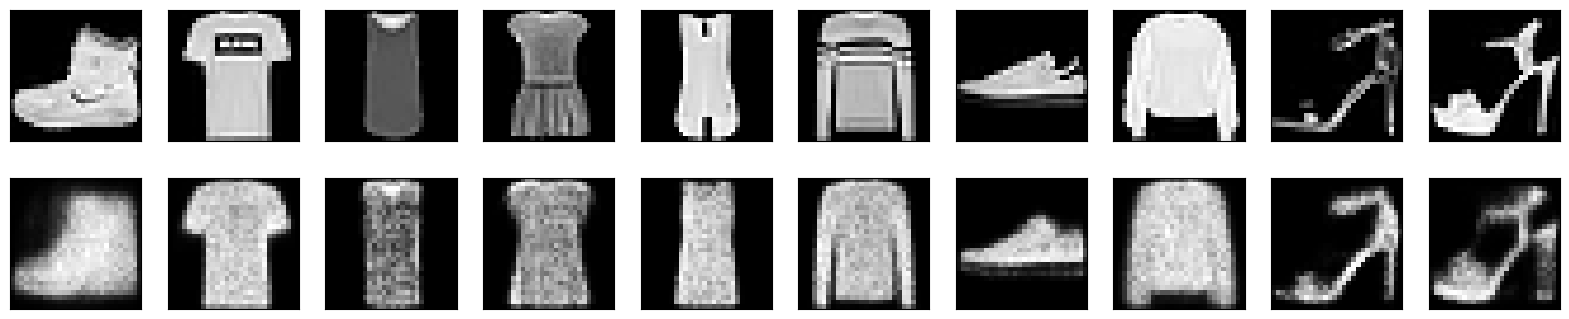

In [24]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_probs.numpy()[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Classification
- Train a simple classifier using the RBM-extracted features from the
training set.
- Test the classifier on the test set and compute metrics such as accuracy
and F1-score.

In [25]:
clf = LogisticRegression(max_iter=1000)
clf.fit(x_train_features, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test_features)

# Evaluate classifier performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# Compare with raw pixel data classification
clf_raw = LogisticRegression(max_iter=1000)
clf_raw.fit(x_train, y_train)

y_pred_raw = clf_raw.predict(x_test)

accuracy_raw = accuracy_score(y_test, y_pred_raw)
f1_raw = f1_score(y_test, y_pred_raw, average='weighted')

print(f'Raw Data Accuracy: {accuracy_raw:.4f}')
print(f'Raw Data F1 Score: {f1_raw:.4f}')

Accuracy: 0.7953
F1 Score: 0.7929
Raw Data Accuracy: 0.8448
Raw Data F1 Score: 0.8440


- RBM helps extract more meaningful features by transforming raw, high-dimensional pixel data into compact, high-level representations that are more suitable for classification.
- These features capture important patterns and structures in the data that raw pixels may miss, leading to improved performance in machine learning tasks.
- The ability to learn sparse, non-linear representations also makes RBMs particularly useful for tasks like image recognition, where the relationships between pixels and objects are complex.